In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-hun6v9ph
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-hun6v9ph
  Resolved https://github.com/tensorflow/docs to commit 940d94cb568bcdd4e82402eff3403ddcf5f874f2
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=2d7b482d288b168a3e8cc67d3a5bc81d8db37e8eb3a1bbb578ebcbea521ed618
  Stored in directory: /tmp/pip-ephem-wheel-cache-cy8qi2zz/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import PIL
import imageio
import glob
from IPython import display

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
drive_path = "gdrive/MyDrive/MachineLearning/HandsOnMachineLearning/chapter17"

Mounted at /content/gdrive


In [30]:
os.makedirs(f"{drive_path}/models", exist_ok=True)
os.makedirs(f"{drive_path}/models/dcgan", exist_ok=True)
os.makedirs(f"{drive_path}/images", exist_ok=True)

# 9.

In [ ]:
train_set, test_set = tfds.load("mnist", as_supervised=True,
                                split=["train[:16000]", "test[:4000]"],
                                shuffle_files=True)
batch_size = 32
denoising_train = train_set.map(lambda img, label: (img/255, img/255))
denoising_train = denoising_train.shuffle(16000).batch(batch_size).prefetch(1)
denoising_test = test_set.map(lambda img, label: (img/255, img/255))
denoising_test = denoising_test.batch(batch_size).prefetch(1)

In [ ]:
X_train = np.array(list(train_set.map(lambda img, label: img/255).as_numpy_iterator()))
y_train = np.array(list(train_set.map(lambda img, label: label).as_numpy_iterator()))
X_test = np.array(list(test_set.map(lambda img, label: img/255).as_numpy_iterator()))
y_test = np.array(list(test_set.map(lambda img, label: label).as_numpy_iterator()))

In [ ]:
gaussian_encoder = keras.models.Sequential([
    layers.GaussianNoise(.1, input_shape=[28, 28, 1]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    layers.Dense(392, activation="relu"),
])
gaussian_decoder = keras.models.Sequential([
    layers.Dense(14*14*16, activation="relu", input_shape=[392]),
    keras.layers.Reshape([14, 14, 16]),
    keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])
gaussian_ae = keras.models.Sequential([gaussian_encoder, gaussian_decoder])

gaussian_ae.compile(optimizer=keras.optimizers.Nadam(),
                    loss="binary_crossentropy", metrics=["mse"])

In [ ]:
gaussian_ae = keras.models.load_model(f"{drive_path}/models/denoise_2024_06_26-12_08_36")

In [ ]:
filepath = time.strftime(f"{drive_path}/models/denoise_%Y_%m_%d-%H_%M_%S")
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
gaussian_ae.fit(denoising_train, epochs=10, validation_data=denoising_test,
                callbacks=[checkpoint_cb])

Epoch 1/10
500/500 [==============================] - 41s 74ms/step - loss: 0.1715 - mse: 0.0362 - val_loss: 0.1332 - val_mse: 0.0229
Epoch 2/10
500/500 [==============================] - 36s 70ms/step - loss: 0.0885 - mse: 0.0089 - val_loss: 0.1085 - val_mse: 0.0150
Epoch 3/10
500/500 [==============================] - 37s 73ms/step - loss: 0.0807 - mse: 0.0064 - val_loss: 0.1002 - val_mse: 0.0124
Epoch 4/10
500/500 [==============================] - 43s 85ms/step - loss: 0.0776 - mse: 0.0054 - val_loss: 0.1009 - val_mse: 0.0125
Epoch 5/10
500/500 [==============================] - 35s 69ms/step - loss: 0.0756 - mse: 0.0048 - val_loss: 0.0947 - val_mse: 0.0106
Epoch 6/10
500/500 [==============================] - 38s 75ms/step - loss: 0.0744 - mse: 0.0044 - val_loss: 0.0934 - val_mse: 0.0102
Epoch 7/10
500/500 [==============================] - 38s 73ms/step - loss: 0.0735 - mse: 0.0041 - val_loss: 0.0904 - val_mse: 0.0093
Epoch 8/10
500/500 [==============================] - 39s 77ms

1/1 [==============================] - 0s 46ms/step


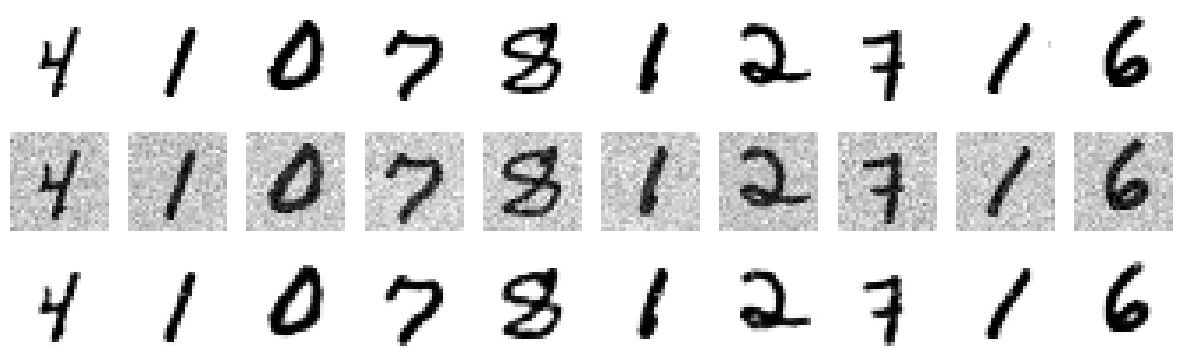

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(X, model, n_images=5):
    noisy_images = X[:n_images] + np.random.randn(n_images, 28, 28, 1) * 0.1
    reconstructions = model.predict(noisy_images)
    fig = plt.figure(figsize=(n_images * 1.5, 4.5))
    for image_index in range(n_images):
        plt.subplot(3, n_images, 1 + image_index)
        plot_image(X[image_index])

        plt.subplot(3, n_images, 1 + n_images + image_index)
        plot_image(noisy_images[image_index])

        plt.subplot(3, n_images, 1 + 2*n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(X_train, gaussian_ae, 10)

In [ ]:
for layer in gaussian_ae.layers[1].layers + gaussian_ae.layers[0].layers:
    layer.trainable = False

clf_model_pretrained = keras.models.Sequential([
    gaussian_ae.layers[0],
    gaussian_ae.layers[1],
    layers.Flatten(),
    layers.Dense(10, activation="softmax")
])
clf_model_pretrained.compile(optimizer=keras.optimizers.Nadam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

In [ ]:
filepath = time.strftime(f"{drive_path}/models/clf_%Y_%m_%d-%H_%M_%S")
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
clf_model_pretrained.fit(X_train[:500], y_train[:500], epochs=10,
                         validation_data=(X_test, y_test),
                         callbacks=[checkpoint_cb])

In [ ]:
clf_model = keras.models.Sequential([
    layers.Flatten(input_shape=[28, 28, 1]),
    layers.Dense(10, activation="softmax")
])
clf_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

In [ ]:
clf_model.fit(X_train[:500], y_train[:500], epochs=10,
                         validation_data=(X_test, y_test))

In [ ]:
gaussian_ae.layers[0].summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_19 (Gaussia  (None, 28, 28, 1)         0         
 nNoise)                                                         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_23 (Flatten)        (None, 3136)              0         
                                                                 
 dense_66 (Dense)            (None, 400)               1254800   
                                                                 
Total params: 1254960 (4.79 MB)
Trainable params: 0 (

500/500 [==============================] - 4s 8ms/step


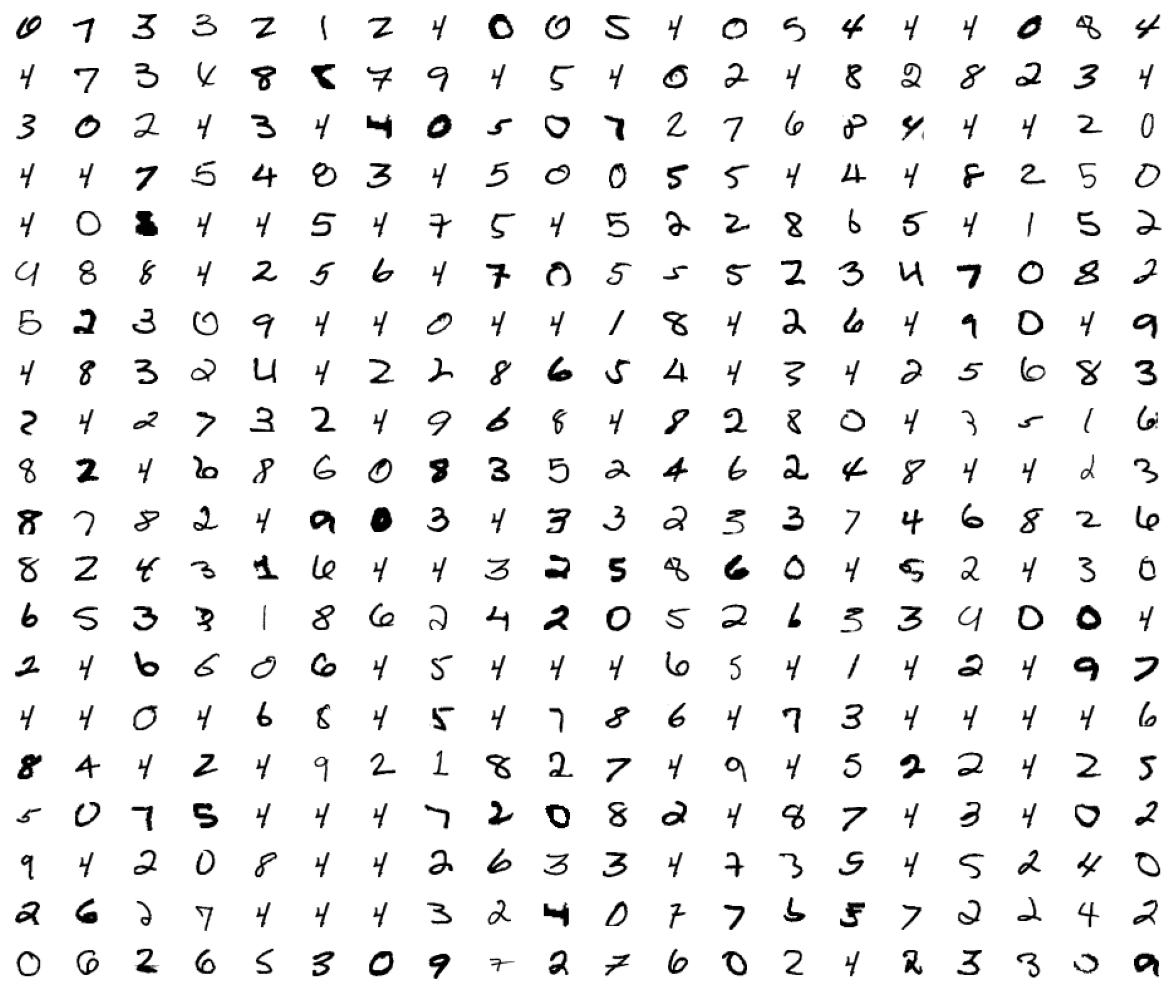

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


coding_layer_model = keras.models.Sequential([
    *gaussian_ae.layers[0].layers
])

activations = coding_layer_model.predict(X_train)

num_neurons = activations.shape[1]
max_activating_images = np.zeros((num_neurons, 28, 28, 1))

for neuron_idx in range(num_neurons):
    neuron_activations = activations[:, neuron_idx]
    max_activation_idx = np.argmax(neuron_activations)
    max_activating_images[neuron_idx] = X_train[max_activation_idx]


n_rows = 20
fig, axes = plt.subplots(n_rows, num_neurons // n_rows, figsize=(12, 10))
axes = axes.ravel()

for i in range(num_neurons):
    axes[i].imshow(max_activating_images[i].squeeze(), cmap='binary')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# 10.

In [ ]:
train_set, test_set = tfds.load("mnist", as_supervised=True,
                                split=["train[:16000]", "test[:4000]"],
                                shuffle_files=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
X_train = np.array(list(train_set.map(lambda img, label: img/255).as_numpy_iterator()))
y_train = np.array(list(train_set.map(lambda img, label: label).as_numpy_iterator()))
X_test = np.array(list(test_set.map(lambda img, label: img/255).as_numpy_iterator()))
y_test = np.array(list(test_set.map(lambda img, label: label).as_numpy_iterator()))

In [ ]:
K = keras.backend


class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
codings_size = 60
inputs = keras.layers.Input(shape=[28, 28, 1])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z) # μ
codings_log_var = keras.layers.Dense(codings_size)(z) # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
)

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28*28*1, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28, 1])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1
)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
filepath = time.strftime(f"{drive_path}/models/variational_%Y_%m_%d-%H_%M_%S")
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
variational_ae.fit(X_train, X_train, epochs=10,
                   validation_data=(X_test, X_test),
                   callbacks=[checkpoint_cb])

Epoch 1/10
500/500 [==============================] - 34s 68ms/step - loss: 0.2618 - val_loss: 0.2206
Epoch 2/10
500/500 [==============================] - 36s 73ms/step - loss: 0.2112 - val_loss: 0.2015
Epoch 3/10
500/500 [==============================] - 40s 81ms/step - loss: 0.1941 - val_loss: 0.1864
Epoch 4/10
500/500 [==============================] - 34s 69ms/step - loss: 0.1825 - val_loss: 0.1766
Epoch 5/10
500/500 [==============================] - 34s 68ms/step - loss: 0.1740 - val_loss: 0.1713
Epoch 6/10
500/500 [==============================] - 36s 72ms/step - loss: 0.1680 - val_loss: 0.1647
Epoch 7/10
500/500 [==============================] - 34s 68ms/step - loss: 0.1635 - val_loss: 0.1615
Epoch 8/10
500/500 [==============================] - 33s 66ms/step - loss: 0.1604 - val_loss: 0.1615
Epoch 9/10
500/500 [==============================] - 40s 80ms/step - loss: 0.1582 - val_loss: 0.1568
Epoch 10/10
500/500 [==============================] - 36s 73ms/step - loss: 0.156

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

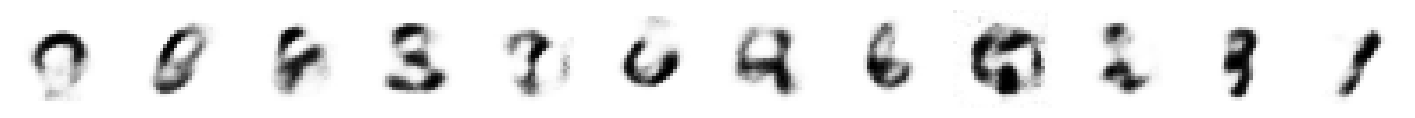

In [ ]:
n_images = 12
codings = tf.random.normal(shape=[n_images, codings_size])
images = variational_decoder(codings).numpy()

fig = plt.figure(figsize=(n_images * 1.5, 1.5))
for image_index, image in enumerate(images):
    plt.subplot(1, n_images, 1 + image_index)
    plot_image(image)

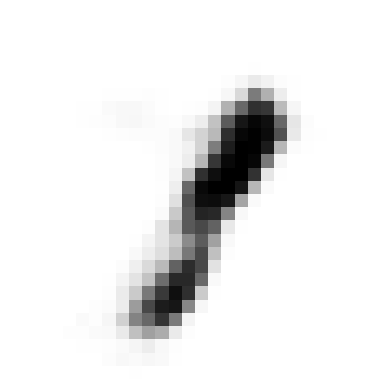

In [ ]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

for image in images:
    plot_image(image)

# 11.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5  # normalize to range [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
CODINGS_SIZE = 100

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    model = keras.models.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=[CODINGS_SIZE,]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape([7, 7, 256]))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1),
                                     padding="same", use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),
                                     padding="same", use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same",
                                     use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 28, 28, 1)

    return model

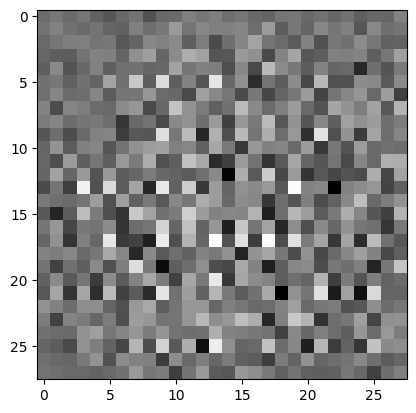

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = keras.models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00021135]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = f"{drive_path}/models/dcgan"
checkpoint_prefix = os.path.join(checkpoint_dir, "dcgan")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
n_examples = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([n_examples, CODINGS_SIZE])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, CODINGS_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images)
        fake_output = discriminator(generated_images)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis("off")

    plt.savefig(f"{drive_path}/images/image_at_epoch_{epoch:04d}.png")
    plt.show()

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

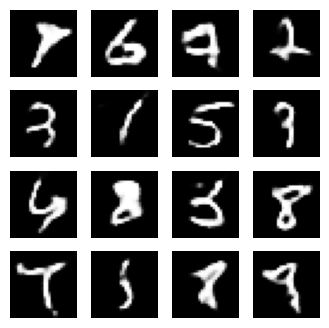

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open(f"{drive_path}/images/image_at_epoch_{epoch_no:04d}.png")

In [ ]:
anim_file = "dcgan.gif"

with imageio.get_writer(anim_file, mode="I") as writer:
  filenames = glob.glob(f"{drive_path}/images/image*.png")
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-27-ba27c0a1d6cf>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-27-ba27c0a1d6cf>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



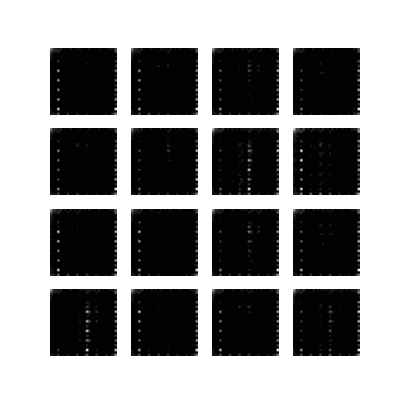

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)